# ALS Speech Classification - Multi-Model Pipeline (ViT, ConvNeXt)

**Using Pre-generated Mel-Spectrogram Images**

This notebook trains models on mel-spectrogram images for dysarthria severity classification.

## Key Features:
- **Minority Class Augmentation**: Handles severe class imbalance
- **Patient-level Evaluation**: Aggregates predictions per patient
- **Focal Loss**: Addresses class imbalance during training

## Model Options:
- **ViT (Vision Transformer)**: Pure attention-based architecture
- **ConvNeXt**: Modern CNN with transformer-inspired design (recommended for medical imaging)
- **AST**: Audio Spectrogram Transformer (pretrained on AudioSet)

## Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

try:
    from transformers import ASTForAudioClassification, ASTConfig, ASTFeatureExtractor
    print("✓ Transformers library available")
except ImportError:
    print("Installing transformers library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'transformers'])
    from transformers import ASTForAudioClassification, ASTConfig, ASTFeatureExtractor
    print("✓ Transformers installed successfully")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count()
print(f"Device: {device}")
print(f"Available GPUs: {n_gpus}")
if n_gpus > 0:
    for i in range(n_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")

✓ Transformers library available
Device: cuda
Available GPUs: 2
  GPU 0: Tesla T4
  Memory: 15.83 GB
  GPU 1: Tesla T4
  Memory: 15.83 GB


## Configuration

## Model Selection Guide

**Current Best: 46% F1 Score (ViT) | Competition Baseline: 60.6% F1**

### Available Models:

1. **ConvNeXt ** 
   - Modern CNN architecture with transformer design principles
   - **Advantages**: 
     - Better inductive bias for spatial patterns in spectrograms
     - ImageNet pretrained weights (transfer learning)
     - More parameter efficient than ViT
     - Better handling of class boundaries (5→4, 3→4 confusion)
   - **Variants**: `tiny` (28M params), `small` (50M), `base` (89M), `large` (198M)
   - **Expected**: 50-60% F1 score with pretrained weights

2. **Vision Transformer (ViT)**
   - Pure attention-based architecture
   - **Advantages**: 
     - Global receptive field from first layer
     - Strong on long-range dependencies
   - **Disadvantages**: 
     - Requires more data (training from scratch)
     - Slower convergence without pretraining
   - **Current**: 46% F1 score

3. **Audio Spectrogram Transformer (AST)**
   - Pretrained on AudioSet
   - **Advantages**: 
     - Audio-specific pretraining
   - **Disadvantages**: 
     - May not transfer well to medical speech

### Recommendation:
Start with **ConvNeXt-Tiny (pretrained=True)** for best balance of performance and efficiency.

In [ ]:
class Config:
    KAGGLE_INPUT = Path('/kaggle/input')
    
    BASE_PATH = KAGGLE_INPUT / 'sand-dataset/train_mel_diffres/train_mel_diffres'
    LABEL_TRAIN = KAGGLE_INPUT / 'sand-dataset/datsetKaggle/datsetKaggle/sand_task_1_train.csv'
    LABEL_TEST = KAGGLE_INPUT / 'sand-dataset/datsetKaggle/datsetKaggle/sand_task_1_val.csv'
    
    MEL_IMAGE_ROOT = KAGGLE_INPUT / 'sand-dataset/train_mel_diffres/train_mel_diffres'  # Adjust to your Kaggle dataset name
    
    if not KAGGLE_INPUT.exists():
        BASE_PATH = Path('/mnt/ml_storage/COMP/IEEE/SAND/SAND_FOLDER/SAND/datsetKaggle')
        LABEL_TRAIN = Path('/mnt/ml_storage/COMP/IEEE/SAND/SAND_FOLDER/SAND/datsetKaggle/sand_task_1_train.csv')
        LABEL_TEST = Path('/mnt/ml_storage/COMP/IEEE/SAND/SAND_FOLDER/SAND/datsetKaggle/sand_task_1_val.csv')
        MEL_IMAGE_ROOT = Path('/mnt/ml_storage/COMP/IEEE/SAND/SAND_FOLDER/SAND/datsetKaggle/train_mel_ori_6848_5')
    
    PHONATION_TASKS = ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU']
    RHYTHM_TASKS = ['rhythmPA', 'rhythmTA', 'rhythmKA']
    ALL_TASKS = PHONATION_TASKS + RHYTHM_TASKS
    
    MODEL_TYPE = 'convnext'  
    
    AST_MODEL_NAME = "MIT/ast-finetuned-audioset-10-10-0.4593" 
    
    IMAGE_SIZE = 224 
    PATCH_SIZE = 16
    NUM_CLASSES = 5
    EMBED_DIM = 768  
    NUM_HEADS = 12    
    NUM_LAYERS = 12 
    MLP_DIM = 3072   
    DROPOUT = 0.1
    
    CONVNEXT_VARIANT = 'base'  # Options: 'tiny', 'small', 'base', 'large'
    CONVNEXT_PRETRAINED = True  # Use ImageNet pretrained weights
    CONVNEXT_DROP_PATH_RATE = 0.1
    
    BATCH_SIZE = 16   
    EPOCHS = 75
    LR = 3e-4
    WEIGHT_DECAY = 0.01
    N_FOLDS = 1
    
    USE_SPECAUGMENT = True  
    SPECAUG_TIME_MASK_PROB = 0.5  
    SPECAUG_FREQ_MASK_PROB = 0.5  
    
    CLASS_AUGMENTATION_MULTIPLIERS = {
        1: 21,  # Class 1: 2.2% -> augment 20x
        2: 5,   # Class 2: 9.6% -> augment 5x
        3: 2,   # Class 3: 19.8% -> augment 2x
        4: 1,   # Class 4: 32.8% -> no augmentation
        5: 1,   # Class 5: 35.6% -> no augmentation
    }

cfg = Config()
print("Configuration loaded")
print(f"Model Type: {cfg.MODEL_TYPE.upper()}")
print(f"MEL Image Root: {cfg.MEL_IMAGE_ROOT}")
print(f"Label CSV: {cfg.LABEL_TRAIN}")
print(f"SpecAugment: {'Enabled' if cfg.USE_SPECAUGMENT else 'Disabled'}")

Configuration loaded
Model Type: CONVNEXT
MEL Image Root: /kaggle/input/sand-dataset/train_mel_diffres/train_mel_diffres
Label CSV: /kaggle/input/sand-dataset/datsetKaggle/datsetKaggle/sand_task_1_train.csv
SpecAugment: Enabled


## Load and Prepare Metadata

In [ ]:
df = pd.read_csv(cfg.LABEL_TRAIN)
print(f"Loaded {len(df)} samples")
print(f"Unique patients: {df['ID'].nunique()}")
print(f"\nClass distribution:")
print(df['Class'].value_counts().sort_index())
print(f"\nClass distribution (%):")
print((df['Class'].value_counts(normalize=True).sort_index() * 100).round(2))

df.head()

Loaded 219 samples
Unique patients: 219

Class distribution:
Class
1     4
2    22
3    45
4    62
5    86
Name: count, dtype: int64

Class distribution (%):
Class
1     1.83
2    10.05
3    20.55
4    28.31
5    39.27
Name: proportion, dtype: float64


,ID,Age,Sex,Class
0,ID000,80,M,5
1,ID001,61,F,5
2,ID002,51,F,4
3,ID003,59,M,3
4,ID005,80,F,5


## Image Dataset with Augmentation for Minority Classes

In [ ]:
class MelSpectrogramDataset(Dataset):
    """
    Dataset for loading pre-generated mel-spectrogram images.
    Handles minority class augmentation by creating augmented copies during initialization.
    """
    def __init__(self, metadata_df, mel_image_root, tasks, transform=None, 
                 is_train=True, augmentation_multipliers=None):

        self.mel_image_root = Path(mel_image_root)
        self.tasks = tasks
        self.transform = transform
        self.is_train = is_train
        
        self.samples = []
        
        for _, row in metadata_df.iterrows():
            subject_id = row['ID']
            class_label = int(row['Class']) - 1
            
            for task in tasks:
                img_filename = f"{subject_id}_{task}.png"
                img_path = self.mel_image_root / task / img_filename
                
                if img_path.exists():
                    self.samples.append({
                        'path': str(img_path),
                        'label': class_label,
                        'subject_id': subject_id,
                        'task': task,
                        'is_augmented': False
                    })
                    
                    if is_train and augmentation_multipliers:
                        true_class = class_label + 1  
                        multiplier = augmentation_multipliers.get(true_class, 1)
                        
                        for aug_idx in range(multiplier - 1):
                            self.samples.append({
                                'path': str(img_path),
                                'label': class_label,
                                'subject_id': subject_id,
                                'task': task,
                                'is_augmented': True
                            })
        
        print(f"Dataset created with {len(self.samples)} samples")
        if is_train:
            self.print_class_distribution()
    
    def print_class_distribution(self):
        """Print class distribution in the dataset."""
        labels = [s['label'] for s in self.samples]
        unique, counts = np.unique(labels, return_counts=True)
        print("Class distribution (0-indexed):")
        for cls, count in zip(unique, counts):
            print(f"  Class {cls} (={cls+1}): {count} samples ({count/len(labels)*100:.1f}%)")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        img = Image.open(sample['path']).convert('RGB')
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(sample['label'], dtype=torch.long)
        
        return img, label, sample['subject_id']

print("MelSpectrogramDataset defined")

MelSpectrogramDataset defined


## Data Transforms (Training & Validation)

In [ ]:
if cfg.USE_SPECAUGMENT:
    train_transform = transforms.Compose([
        transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        # SpecAugment: Time masking (horizontal stripes)
        transforms.RandomErasing(p=cfg.SPECAUG_TIME_MASK_PROB, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
        # SpecAugment: Frequency masking (vertical stripes)
        transforms.RandomErasing(p=cfg.SPECAUG_FREQ_MASK_PROB, scale=(0.02, 0.1), ratio=(0.1, 10), value=0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined")
if cfg.USE_SPECAUGMENT:
    print("✓ SpecAugment enabled (time + frequency masking)")

Transforms defined
✓ SpecAugment enabled (time + frequency masking)


## Vision Transformer (ViT) Model

*Note: This section defines the ViT architecture. If using AST mode, these classes won't be instantiated but must be defined for the `create_model()` function.*

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)  
        x = x.transpose(1, 2)  
        return x


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, dropout)
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5,
                 embed_dim=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        cls_output = x[:, 0]
        logits = self.head(cls_output)
        return logits

print("Vision Transformer model defined")

Vision Transformer model defined


## ConvNeXt Model

ConvNeXt is a modern CNN architecture that incorporates design principles from transformers while maintaining the efficiency of CNNs. It's particularly good for visual recognition tasks.

In [ ]:
class LayerNorm2d(nn.Module):
    """LayerNorm for channels-first (NCHW) tensors."""
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps
    
    def forward(self, x):
        # x: (B, C, H, W)
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


class ConvNeXtBlock(nn.Module):
    """ConvNeXt Block: DWConv -> LayerNorm -> 1x1 Conv -> GELU -> 1x1 Conv -> Drop Path"""
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  
        self.norm = LayerNorm2d(dim)
        self.pwconv1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)  
        self.act = nn.GELU()
        self.pwconv2 = nn.Conv2d(4 * dim, dim, kernel_size=1)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim)) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
    
    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma[:, None, None] * x
        x = shortcut + self.drop_path(x)
        return x


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob
    
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # Binarize
        output = x.div(keep_prob) * random_tensor
        return output


class ConvNeXt(nn.Module):
  
    def __init__(self, in_chans=3, num_classes=5, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768],
                 drop_path_rate=0., layer_scale_init_value=1e-6):
        super().__init__()
        
        # Stem: 4x4 conv with stride 4
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0])
        )
        
        # Build stages
        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        
        for i in range(4):
            # Downsampling layer (except first stage)
            if i > 0:
                downsample = nn.Sequential(
                    LayerNorm2d(dims[i-1]),
                    nn.Conv2d(dims[i-1], dims[i], kernel_size=2, stride=2)
                )
            else:
                downsample = nn.Identity()
            
            # Stage blocks
            stage = nn.Sequential(
                downsample,
                *[ConvNeXtBlock(dim=dims[i], drop_path=dp_rates[cur + j],
                               layer_scale_init_value=layer_scale_init_value)
                  for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]
        
        # Head
        self.norm = LayerNorm2d(dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = self.norm(x)
        x = x.mean([-2, -1])  # Global average pooling
        x = self.head(x)
        return x


def convnext_tiny(num_classes=5, drop_path_rate=0., pretrained=False):
    """ConvNeXt-Tiny model"""
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768],
                     num_classes=num_classes, drop_path_rate=drop_path_rate)
    
    if pretrained:
        try:
            # Load ImageNet pretrained weights from torchvision
            import torchvision.models as models
            pretrained_model = models.convnext_tiny(weights='IMAGENET1K_V1')
            
            # Copy all weights except final classifier
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_model.state_dict().items() 
                             if k in model_dict and 'head' not in k}
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            print("✓ Loaded ImageNet pretrained weights for ConvNeXt-Tiny")
        except Exception as e:
            print(f"⚠ Could not load pretrained weights: {e}")
            print("  Training from scratch...")
    
    return model


def convnext_small(num_classes=5, drop_path_rate=0., pretrained=False):
    """ConvNeXt-Small model"""
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768],
                     num_classes=num_classes, drop_path_rate=drop_path_rate)
    
    if pretrained:
        try:
            import torchvision.models as models
            pretrained_model = models.convnext_small(weights='IMAGENET1K_V1')
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_model.state_dict().items() 
                             if k in model_dict and 'head' not in k}
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            print("✓ Loaded ImageNet pretrained weights for ConvNeXt-Small")
        except Exception as e:
            print(f"⚠ Could not load pretrained weights: {e}")
    
    return model


def convnext_base(num_classes=5, drop_path_rate=0., pretrained=False):
    """ConvNeXt-Base model"""
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024],
                     num_classes=num_classes, drop_path_rate=drop_path_rate)
    
    if pretrained:
        try:
            import torchvision.models as models
            pretrained_model = models.convnext_base(weights='IMAGENET1K_V1')
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_model.state_dict().items() 
                             if k in model_dict and 'head' not in k}
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            print("✓ Loaded ImageNet pretrained weights for ConvNeXt-Base")
        except Exception as e:
            print(f"⚠ Could not load pretrained weights: {e}")
    
    return model


def convnext_large(num_classes=5, drop_path_rate=0., pretrained=False):
    """ConvNeXt-Large model"""
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536],
                     num_classes=num_classes, drop_path_rate=drop_path_rate)
    
    if pretrained:
        try:
            import torchvision.models as models
            pretrained_model = models.convnext_large(weights='IMAGENET1K_V1')
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_model.state_dict().items() 
                             if k in model_dict and 'head' not in k}
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            print("✓ Loaded ImageNet pretrained weights for ConvNeXt-Large")
        except Exception as e:
            print(f"⚠ Could not load pretrained weights: {e}")
    
    return model


print("ConvNeXt models defined (Tiny, Small, Base, Large)")

ConvNeXt models defined (Tiny, Small, Base, Large)


## Model Creation Function

In [ ]:
def create_model(device):
    """Create model based on Config.MODEL_TYPE ('ast', 'vit', or 'convnext')"""
    
    if cfg.MODEL_TYPE == 'ast':
        print(f"Loading pretrained AST model: {cfg.AST_MODEL_NAME}")
        

        class ASTImageWrapper(nn.Module):
            def __init__(self, ast_model):
                super().__init__()
                self.ast_model = ast_model
            
            def forward(self, x):
                # x shape: (B, 3, H, W) - RGB image
                # Convert RGB to grayscale: weighted average
                # Use luminosity method: 0.299*R + 0.587*G + 0.114*B
                if x.shape[1] == 3:
                    x = 0.299 * x[:, 0:1, :, :] + 0.587 * x[:, 1:2, :, :] + 0.114 * x[:, 2:3, :, :]
                # x shape now: (B, 1, H, W)
                
                # AST expects (B, 1, time_steps, freq_bins) = (B, 1, H, W)
                return self.ast_model(x)
        
        base_model = ASTForAudioClassification.from_pretrained(
            cfg.AST_MODEL_NAME,
            num_labels=cfg.NUM_CLASSES,
            ignore_mismatched_sizes=True  # Allow classifier head replacement
        )
        
        model = ASTImageWrapper(base_model)

        print(f"✓ AST model loaded with {cfg.NUM_CLASSES} output classes")
        print(f"✓ Wrapped to handle RGB -> Grayscale conversion")
        print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
        
    elif cfg.MODEL_TYPE == 'vit':
        print("Creating ViT model from scratch")
        model = VisionTransformer(
            img_size=cfg.IMAGE_SIZE,
            patch_size=cfg.PATCH_SIZE,
            num_classes=cfg.NUM_CLASSES,
            embed_dim=cfg.EMBED_DIM,
            num_heads=cfg.NUM_HEADS,
            num_layers=cfg.NUM_LAYERS,
            mlp_dim=cfg.MLP_DIM,
            dropout=cfg.DROPOUT
        )
        print(f"✓ ViT model created")
        print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    elif cfg.MODEL_TYPE == 'convnext':
        # ConvNeXt (pretrained or from scratch)
        print(f"Creating ConvNeXt-{cfg.CONVNEXT_VARIANT.upper()} model")
        
        variant_map = {
            'tiny': convnext_tiny,
            'small': convnext_small,
            'base': convnext_base,
            'large': convnext_large
        }
        
        if cfg.CONVNEXT_VARIANT.lower() not in variant_map:
            raise ValueError(f"Unknown ConvNeXt variant: {cfg.CONVNEXT_VARIANT}. Choose from: {list(variant_map.keys())}")
        
        model_fn = variant_map[cfg.CONVNEXT_VARIANT.lower()]
        model = model_fn(
            num_classes=cfg.NUM_CLASSES,
            drop_path_rate=cfg.CONVNEXT_DROP_PATH_RATE,
            pretrained=cfg.CONVNEXT_PRETRAINED
        )
        
        print(f"✓ ConvNeXt-{cfg.CONVNEXT_VARIANT.upper()} model created")
        if cfg.CONVNEXT_PRETRAINED:
            print(f"  Using ImageNet pretrained weights (transfer learning)")
        else:
            print(f"  Training from scratch")
        print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    else:
        raise ValueError(f"Unknown model type: {cfg.MODEL_TYPE}. Use 'ast', 'vit', or 'convnext'")
    
    return model.to(device)

print("Model creation function defined")

Model creation function defined


## Focal Loss (for Class Imbalance)

In [20]:
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance."""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        p_t = torch.exp(-ce_loss)
        focal_loss = ((1 - p_t) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("Focal Loss defined")

Focal Loss defined


## Training and Evaluation Functions

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, scaler, device, epoch):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, labels, _ in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(images)
            
            # Handle AST output (dict with 'logits') vs ViT output (tensor)
            if isinstance(outputs, dict):
                logits = outputs['logits']
            else:
                logits = outputs
            
            loss = criterion(logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return epoch_loss, epoch_f1


def evaluate(model, dataloader, criterion, device):
    """Evaluate model on validation set."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_subject_ids = []
    
    with torch.no_grad():
        for images, labels, subject_ids in tqdm(dataloader, desc="[Val]"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Handle AST output (dict with 'logits') vs ViT output (tensor)
            if isinstance(outputs, dict):
                logits = outputs['logits']
            else:
                logits = outputs
            
            loss = criterion(logits, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_subject_ids.extend(subject_ids)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Sample-level metrics
    sample_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Patient-level aggregation (majority vote)
    patient_preds = {}
    patient_labels = {}
    for pred, label, sid in zip(all_preds, all_labels, all_subject_ids):
        if sid not in patient_preds:
            patient_preds[sid] = []
            patient_labels[sid] = label
        patient_preds[sid].append(pred)
    
    # Majority vote per patient
    final_patient_preds = []
    final_patient_labels = []
    patient_ids_list = []
    for sid in patient_preds.keys():
        majority_pred = np.bincount(patient_preds[sid]).argmax()
        final_patient_preds.append(majority_pred)
        final_patient_labels.append(patient_labels[sid])
        patient_ids_list.append(sid)
    
    patient_f1 = f1_score(final_patient_labels, final_patient_preds, average='macro', zero_division=0)
    
    # Find misclassified patients
    misclassified = []
    for sid, true_label, pred_label in zip(patient_ids_list, final_patient_labels, final_patient_preds):
        if true_label != pred_label:
            misclassified.append({
                'id': sid,
                'true_class': true_label + 1,  # Convert back to 1-indexed
                'pred_class': pred_label + 1   # Convert back to 1-indexed
            })
    
    return epoch_loss, sample_f1, patient_f1, final_patient_labels, final_patient_preds, misclassified

print("Training and evaluation functions defined")

Training and evaluation functions defined


## Main Training Loop with K-Fold Cross-Validation

In [ ]:
# Load train and validation data separately
train_df = pd.read_csv(cfg.LABEL_TRAIN)
val_df = pd.read_csv(cfg.LABEL_TEST)

print(f"Training set: {len(train_df)} patients")
print(f"Validation set: {len(val_df)} patients")
print(f"\nTrain class distribution:")
print(train_df['Class'].value_counts().sort_index())
print(f"\nVal class distribution:")
print(val_df['Class'].value_counts().sort_index())

# Create datasets with augmentation for training
train_dataset = MelSpectrogramDataset(
    train_df, cfg.MEL_IMAGE_ROOT, cfg.ALL_TASKS,
    transform=train_transform, is_train=True,
    augmentation_multipliers=cfg.CLASS_AUGMENTATION_MULTIPLIERS
)

val_dataset = MelSpectrogramDataset(
    val_df, cfg.MEL_IMAGE_ROOT, cfg.ALL_TASKS,
    transform=val_transform, is_train=False
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Model
model = create_model(device)

# Multi-GPU if available
if n_gpus > 1:
    model = nn.DataParallel(model)
    print(f"Using DataParallel on {n_gpus} GPUs")

# Compute class weights for Focal Loss
train_labels = [s['label'] for s in train_dataset.samples]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = torch.FloatTensor(class_weights).to(device)

# Loss, optimizer, scaler
criterion = FocalLoss(alpha=class_weights, gamma=2.0)


if cfg.MODEL_TYPE == 'ast':
    learning_rate = 1e-4
elif cfg.MODEL_TYPE == 'convnext' and cfg.CONVNEXT_PRETRAINED:
    learning_rate = 1e-4  # Lower LR for pretrained ConvNeXt
elif cfg.MODEL_TYPE == 'convnext' and not cfg.CONVNEXT_PRETRAINED:
    learning_rate = cfg.LR  # Standard LR for training from scratch
else:  # ViT from scratch
    learning_rate = cfg.LR

print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {cfg.WEIGHT_DECAY}")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=cfg.WEIGHT_DECAY)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

# Training loop
best_patient_f1 = 0.0
best_misclassified = []
history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_sample_f1': [], 'val_patient_f1': []}

print(f"\n{'='*60}")
print("STARTING TRAINING")
print(f"{'='*60}\n")

for epoch in range(1, cfg.EPOCHS + 1):
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch)
    val_loss, val_sample_f1, val_patient_f1, val_labels, val_preds, misclassified = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_sample_f1'].append(val_sample_f1)
    history['val_patient_f1'].append(val_patient_f1)
    
    print(f"Epoch {epoch}/{cfg.EPOCHS} - Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"               Val Loss: {val_loss:.4f}, Val Sample F1: {val_sample_f1:.4f}, Val Patient F1: {val_patient_f1:.4f}")
    
    # Save best model
    if val_patient_f1 > best_patient_f1:
        best_patient_f1 = val_patient_f1
        best_misclassified = misclassified
        model_name = f'best_{cfg.MODEL_TYPE}_model.pth'
        torch.save(model.state_dict(), model_name)
        print(f"  ✓ Saved best model: {model_name} (Patient F1: {best_patient_f1:.4f})")

# Display misclassified patients from best epoch
print(f"\n{'='*60}")
print(f"MISCLASSIFIED PATIENTS (Best Epoch)")
print(f"{'='*60}")
if len(best_misclassified) > 0:
    print(f"Total misclassified: {len(best_misclassified)}")
    print(f"\n{'ID':<15} {'True Class':<12} {'Predicted Class'}")
    print("-" * 45)
    for item in best_misclassified:
        print(f"{item['id']:<15} {item['true_class']:<12} {item['pred_class']}")
else:
    print("No misclassifications! Perfect predictions!")
print()

# Final summary
print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Best Validation Patient F1: {best_patient_f1:.4f}")

Training set: 219 patients
Validation set: 53 patients

Train class distribution:
Class
1     4
2    22
3    45
4    62
5    86
Name: count, dtype: int64

Val class distribution:
Class
1     2
2     4
3    12
4    14
5    21
Name: count, dtype: int64
Dataset created with 3456 samples
Class distribution (0-indexed):
  Class 0 (=1): 672 samples (19.4%)
  Class 1 (=2): 880 samples (25.5%)
  Class 2 (=3): 720 samples (20.8%)
  Class 3 (=4): 496 samples (14.4%)
  Class 4 (=5): 688 samples (19.9%)
Dataset created with 424 samples
Creating ConvNeXt-BASE model
✓ Loaded ImageNet pretrained weights for ConvNeXt-Base
✓ ConvNeXt-BASE model created
  Using ImageNet pretrained weights (transfer learning)
  Total parameters: 87,571,589
  Trainable parameters: 87,571,589
Using DataParallel on 2 GPUs
Learning rate: 0.0001
Weight decay: 0.01

STARTING TRAINING



Epoch 1 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/75 - Train Loss: 1.0140, Train F1: 0.2150
               Val Loss: 0.9273, Val Sample F1: 0.2194, Val Patient F1: 0.1783
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.1783)


Epoch 2 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/75 - Train Loss: 0.9025, Train F1: 0.2744
               Val Loss: 1.1389, Val Sample F1: 0.2220, Val Patient F1: 0.2324
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.2324)


Epoch 3 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/75 - Train Loss: 0.7838, Train F1: 0.3274
               Val Loss: 0.9057, Val Sample F1: 0.2055, Val Patient F1: 0.1673


Epoch 4 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/75 - Train Loss: 0.7194, Train F1: 0.3621
               Val Loss: 0.8102, Val Sample F1: 0.3078, Val Patient F1: 0.2750
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.2750)


Epoch 5 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5/75 - Train Loss: 0.6932, Train F1: 0.3575
               Val Loss: 0.9440, Val Sample F1: 0.3182, Val Patient F1: 0.3411
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.3411)


Epoch 6 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/75 - Train Loss: 0.6572, Train F1: 0.3788
               Val Loss: 0.9361, Val Sample F1: 0.2662, Val Patient F1: 0.2887


Epoch 7 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/75 - Train Loss: 0.6427, Train F1: 0.3819
               Val Loss: 0.8504, Val Sample F1: 0.3007, Val Patient F1: 0.2595


Epoch 8 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/75 - Train Loss: 0.6182, Train F1: 0.3936
               Val Loss: 0.9303, Val Sample F1: 0.2786, Val Patient F1: 0.2863


Epoch 9 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9/75 - Train Loss: 0.6059, Train F1: 0.4205
               Val Loss: 0.8841, Val Sample F1: 0.3243, Val Patient F1: 0.3151


Epoch 10 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/75 - Train Loss: 0.5888, Train F1: 0.4137
               Val Loss: 0.8706, Val Sample F1: 0.3779, Val Patient F1: 0.4124
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.4124)


Epoch 11 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11/75 - Train Loss: 0.5724, Train F1: 0.4292
               Val Loss: 0.9414, Val Sample F1: 0.3046, Val Patient F1: 0.2815


Epoch 12 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12/75 - Train Loss: 0.5619, Train F1: 0.4430
               Val Loss: 0.7774, Val Sample F1: 0.4051, Val Patient F1: 0.4815
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.4815)


Epoch 13 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13/75 - Train Loss: 0.5615, Train F1: 0.4541
               Val Loss: 0.9249, Val Sample F1: 0.3419, Val Patient F1: 0.4168


Epoch 14 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14/75 - Train Loss: 0.5439, Train F1: 0.4499
               Val Loss: 0.9076, Val Sample F1: 0.4138, Val Patient F1: 0.4693


Epoch 15 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15/75 - Train Loss: 0.5385, Train F1: 0.4673
               Val Loss: 0.8195, Val Sample F1: 0.3440, Val Patient F1: 0.3053


Epoch 16 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16/75 - Train Loss: 0.5324, Train F1: 0.4804
               Val Loss: 0.9299, Val Sample F1: 0.3905, Val Patient F1: 0.4923
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.4923)


Epoch 17 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17/75 - Train Loss: 0.5251, Train F1: 0.4745
               Val Loss: 1.0186, Val Sample F1: 0.3470, Val Patient F1: 0.4250


Epoch 18 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18/75 - Train Loss: 0.5179, Train F1: 0.4896
               Val Loss: 0.7740, Val Sample F1: 0.3727, Val Patient F1: 0.4221


Epoch 19 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19/75 - Train Loss: 0.5181, Train F1: 0.4796
               Val Loss: 0.7844, Val Sample F1: 0.3737, Val Patient F1: 0.4127


Epoch 20 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20/75 - Train Loss: 0.5066, Train F1: 0.4929
               Val Loss: 0.7382, Val Sample F1: 0.4092, Val Patient F1: 0.4134


Epoch 21 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21/75 - Train Loss: 0.4993, Train F1: 0.4887
               Val Loss: 0.7524, Val Sample F1: 0.3797, Val Patient F1: 0.3747


Epoch 22 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22/75 - Train Loss: 0.4917, Train F1: 0.5019
               Val Loss: 0.8632, Val Sample F1: 0.2986, Val Patient F1: 0.2656


Epoch 23 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23/75 - Train Loss: 0.4890, Train F1: 0.5113
               Val Loss: 0.7510, Val Sample F1: 0.3939, Val Patient F1: 0.3831


Epoch 24 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24/75 - Train Loss: 0.4816, Train F1: 0.5084
               Val Loss: 0.7337, Val Sample F1: 0.4622, Val Patient F1: 0.4810


Epoch 25 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25/75 - Train Loss: 0.4760, Train F1: 0.5241
               Val Loss: 0.7649, Val Sample F1: 0.4278, Val Patient F1: 0.5058
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.5058)


Epoch 26 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26/75 - Train Loss: 0.4765, Train F1: 0.5132
               Val Loss: 0.8610, Val Sample F1: 0.4211, Val Patient F1: 0.4870


Epoch 27 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27/75 - Train Loss: 0.4713, Train F1: 0.5120
               Val Loss: 0.8082, Val Sample F1: 0.3576, Val Patient F1: 0.3285


Epoch 28 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28/75 - Train Loss: 0.4678, Train F1: 0.5280
               Val Loss: 0.8312, Val Sample F1: 0.3839, Val Patient F1: 0.4130


Epoch 29 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29/75 - Train Loss: 0.4643, Train F1: 0.5286
               Val Loss: 0.8855, Val Sample F1: 0.3485, Val Patient F1: 0.3893


Epoch 30 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30/75 - Train Loss: 0.4539, Train F1: 0.5385
               Val Loss: 0.7482, Val Sample F1: 0.4047, Val Patient F1: 0.4350


Epoch 31 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31/75 - Train Loss: 0.4469, Train F1: 0.5377
               Val Loss: 0.8076, Val Sample F1: 0.3930, Val Patient F1: 0.3906


Epoch 32 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32/75 - Train Loss: 0.4490, Train F1: 0.5336
               Val Loss: 0.7656, Val Sample F1: 0.3844, Val Patient F1: 0.5005


Epoch 33 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33/75 - Train Loss: 0.4395, Train F1: 0.5428
               Val Loss: 0.7457, Val Sample F1: 0.3499, Val Patient F1: 0.3850


Epoch 34 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34/75 - Train Loss: 0.4361, Train F1: 0.5534
               Val Loss: 0.7646, Val Sample F1: 0.4122, Val Patient F1: 0.5224
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.5224)


Epoch 35 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35/75 - Train Loss: 0.4436, Train F1: 0.5482
               Val Loss: 0.7448, Val Sample F1: 0.3992, Val Patient F1: 0.4584


Epoch 36 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36/75 - Train Loss: 0.4337, Train F1: 0.5569
               Val Loss: 0.7991, Val Sample F1: 0.4341, Val Patient F1: 0.5021


Epoch 37 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37/75 - Train Loss: 0.4229, Train F1: 0.5696
               Val Loss: 0.7921, Val Sample F1: 0.3843, Val Patient F1: 0.3871


Epoch 38 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38/75 - Train Loss: 0.4286, Train F1: 0.5536
               Val Loss: 0.7899, Val Sample F1: 0.3946, Val Patient F1: 0.4484


Epoch 39 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39/75 - Train Loss: 0.4127, Train F1: 0.5667
               Val Loss: 0.7892, Val Sample F1: 0.4322, Val Patient F1: 0.4613


Epoch 40 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40/75 - Train Loss: 0.4178, Train F1: 0.5672
               Val Loss: 0.7678, Val Sample F1: 0.4168, Val Patient F1: 0.4885


Epoch 41 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41/75 - Train Loss: 0.4155, Train F1: 0.5726
               Val Loss: 0.7908, Val Sample F1: 0.3920, Val Patient F1: 0.4000


Epoch 42 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42/75 - Train Loss: 0.4062, Train F1: 0.5819
               Val Loss: 0.7952, Val Sample F1: 0.4309, Val Patient F1: 0.4658


Epoch 43 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43/75 - Train Loss: 0.4098, Train F1: 0.5752
               Val Loss: 0.7923, Val Sample F1: 0.3829, Val Patient F1: 0.4370


Epoch 44 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44/75 - Train Loss: 0.4025, Train F1: 0.5896
               Val Loss: 0.7915, Val Sample F1: 0.3375, Val Patient F1: 0.3659


Epoch 45 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45/75 - Train Loss: 0.4013, Train F1: 0.5804
               Val Loss: 0.7773, Val Sample F1: 0.4321, Val Patient F1: 0.5532
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.5532)


Epoch 46 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46/75 - Train Loss: 0.3990, Train F1: 0.5866
               Val Loss: 0.8369, Val Sample F1: 0.4068, Val Patient F1: 0.4391


Epoch 47 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47/75 - Train Loss: 0.3967, Train F1: 0.6004
               Val Loss: 0.7697, Val Sample F1: 0.4237, Val Patient F1: 0.5977
  ✓ Saved best model: best_convnext_model.pth (Patient F1: 0.5977)


Epoch 48 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48/75 - Train Loss: 0.3911, Train F1: 0.5885
               Val Loss: 0.8045, Val Sample F1: 0.4367, Val Patient F1: 0.5433


Epoch 49 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49/75 - Train Loss: 0.3895, Train F1: 0.5865
               Val Loss: 0.8151, Val Sample F1: 0.3910, Val Patient F1: 0.5476


Epoch 50 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 50/75 - Train Loss: 0.3827, Train F1: 0.5999
               Val Loss: 0.7856, Val Sample F1: 0.4432, Val Patient F1: 0.5712


Epoch 51 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 51/75 - Train Loss: 0.3846, Train F1: 0.6029
               Val Loss: 0.7845, Val Sample F1: 0.4256, Val Patient F1: 0.5045


Epoch 52 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 52/75 - Train Loss: 0.3845, Train F1: 0.6103
               Val Loss: 0.7704, Val Sample F1: 0.4091, Val Patient F1: 0.5234


Epoch 53 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 53/75 - Train Loss: 0.3741, Train F1: 0.6109
               Val Loss: 0.7937, Val Sample F1: 0.4002, Val Patient F1: 0.5694


Epoch 54 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 54/75 - Train Loss: 0.3735, Train F1: 0.6055
               Val Loss: 0.8240, Val Sample F1: 0.4064, Val Patient F1: 0.4848


Epoch 55 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 55/75 - Train Loss: 0.3635, Train F1: 0.6171
               Val Loss: 0.7958, Val Sample F1: 0.4187, Val Patient F1: 0.5573


Epoch 56 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 56/75 - Train Loss: 0.3705, Train F1: 0.6061
               Val Loss: 0.8229, Val Sample F1: 0.4105, Val Patient F1: 0.5698


Epoch 57 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 57/75 - Train Loss: 0.3603, Train F1: 0.6248
               Val Loss: 0.8541, Val Sample F1: 0.4178, Val Patient F1: 0.5094


Epoch 58 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 58/75 - Train Loss: 0.3683, Train F1: 0.6133
               Val Loss: 0.7736, Val Sample F1: 0.4260, Val Patient F1: 0.5605


Epoch 59 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 59/75 - Train Loss: 0.3653, Train F1: 0.5989
               Val Loss: 0.8073, Val Sample F1: 0.4365, Val Patient F1: 0.5480


Epoch 60 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 60/75 - Train Loss: 0.3644, Train F1: 0.6170
               Val Loss: 0.8083, Val Sample F1: 0.4414, Val Patient F1: 0.5449


Epoch 61 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 61/75 - Train Loss: 0.3534, Train F1: 0.6181
               Val Loss: 0.8100, Val Sample F1: 0.4073, Val Patient F1: 0.5335


Epoch 62 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 62/75 - Train Loss: 0.3618, Train F1: 0.6104
               Val Loss: 0.8063, Val Sample F1: 0.4191, Val Patient F1: 0.5832


Epoch 63 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 63/75 - Train Loss: 0.3588, Train F1: 0.6141
               Val Loss: 0.7868, Val Sample F1: 0.4220, Val Patient F1: 0.5343


Epoch 64 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 64/75 - Train Loss: 0.3508, Train F1: 0.6198
               Val Loss: 0.7923, Val Sample F1: 0.4218, Val Patient F1: 0.5564


Epoch 65 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 65/75 - Train Loss: 0.3531, Train F1: 0.6209
               Val Loss: 0.7949, Val Sample F1: 0.4251, Val Patient F1: 0.5144


Epoch 66 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 66/75 - Train Loss: 0.3569, Train F1: 0.6128
               Val Loss: 0.7856, Val Sample F1: 0.4184, Val Patient F1: 0.5744


Epoch 67 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 67/75 - Train Loss: 0.3504, Train F1: 0.6216
               Val Loss: 0.8081, Val Sample F1: 0.3999, Val Patient F1: 0.5487


Epoch 68 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 68/75 - Train Loss: 0.3497, Train F1: 0.6263
               Val Loss: 0.7904, Val Sample F1: 0.4391, Val Patient F1: 0.5676


Epoch 69 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 69/75 - Train Loss: 0.3434, Train F1: 0.6388
               Val Loss: 0.7984, Val Sample F1: 0.4328, Val Patient F1: 0.5539


Epoch 70 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 70/75 - Train Loss: 0.3518, Train F1: 0.6292
               Val Loss: 0.7891, Val Sample F1: 0.4379, Val Patient F1: 0.5676


Epoch 71 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 71/75 - Train Loss: 0.3453, Train F1: 0.6151
               Val Loss: 0.7958, Val Sample F1: 0.4345, Val Patient F1: 0.5625


Epoch 72 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 72/75 - Train Loss: 0.3516, Train F1: 0.6212
               Val Loss: 0.7937, Val Sample F1: 0.4269, Val Patient F1: 0.5625


Epoch 73 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 73/75 - Train Loss: 0.3510, Train F1: 0.6250
               Val Loss: 0.7964, Val Sample F1: 0.4269, Val Patient F1: 0.5625


Epoch 74 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 74/75 - Train Loss: 0.3440, Train F1: 0.6299
               Val Loss: 0.7955, Val Sample F1: 0.4269, Val Patient F1: 0.5625


Epoch 75 [Train]:   0%|          | 0/216 [00:00<?, ?it/s]

[Val]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 75/75 - Train Loss: 0.3451, Train F1: 0.6249
               Val Loss: 0.7960, Val Sample F1: 0.4269, Val Patient F1: 0.5625

MISCLASSIFIED PATIENTS (Best Epoch)
Total misclassified: 22

ID              True Class   Predicted Class
---------------------------------------------
ID007           3            4
ID012           5            4
ID037           5            4
ID054           5            4
ID056           3            4
ID075           4            5
ID083           5            4
ID099           5            4
ID101           5            4
ID136           5            4
ID138           1            2
ID176           3            2
ID179           4            3
ID202           5            4
ID209           2            3
ID227           3            5
ID263           3            5
ID269           5            4
ID274           4            2
ID278           5            2
ID302           5            4
ID323           5            3


TRAINING COMPLETE
Best Validation

## Visualization and Final Results

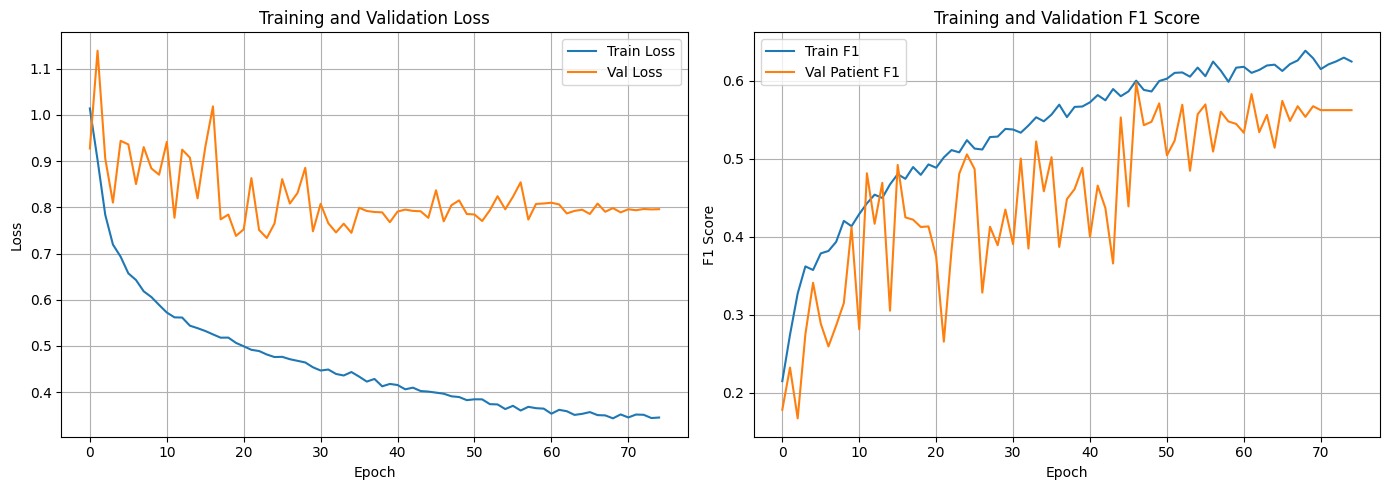

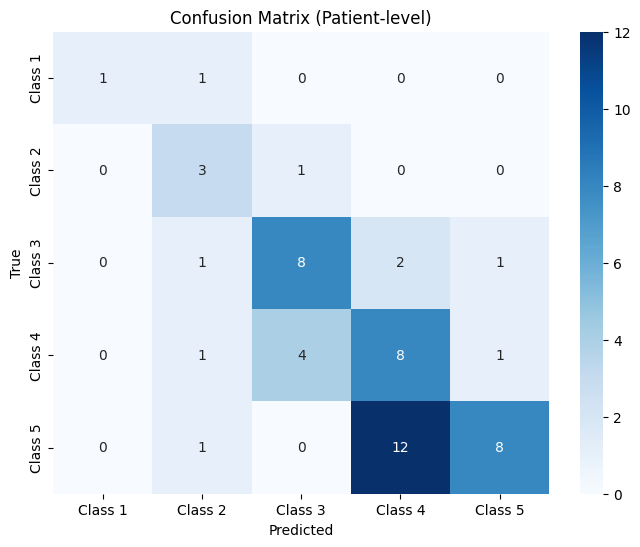


Classification Report (Patient-level):
              precision    recall  f1-score   support

     Class 1       1.00      0.50      0.67         2
     Class 2       0.43      0.75      0.55         4
     Class 3       0.62      0.67      0.64        12
     Class 4       0.36      0.57      0.44        14
     Class 5       0.80      0.38      0.52        21

    accuracy                           0.53        53
   macro avg       0.64      0.57      0.56        53
weighted avg       0.62      0.53      0.53        53



In [23]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# F1 Score
axes[1].plot(history['train_f1'], label='Train F1')
axes[1].plot(history['val_patient_f1'], label='Val Patient F1')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Training and Validation F1 Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i+1}' for i in range(5)],
            yticklabels=[f'Class {i+1}' for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Patient-level)')
plt.show()

# Classification report
print("\nClassification Report (Patient-level):")
print(classification_report(val_labels, val_preds, 
                           target_names=[f'Class {i+1}' for i in range(5)],
                           zero_division=0))